# Bank Marketing UCI Modeling

Tried
* Loans - combibation of 'housing' and 'loans' - didn't improve model
* Prev_contacted - didn't improve model
* Employed_cat - nr.employed ? 5090 - improved without nr.employed

Notes
* Scaler for svc
* Different optuna trials, samplers
* Remove 'default' feature
* Add save for optuna study
* Add knn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, balanced_accuracy_score 
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import optuna
import shap
import modelplotpy as mp
import category_encoders as ce
from sklearn.metrics import ConfusionMatrixDisplay

### Import data

In [2]:
def read_data(path: str, files: list):
    dataframes = []
    for file in files:
        dataframes.append(pd.read_csv(path + file, sep=','))
    return dataframes


path = '../data/'
files = ['bank_data.csv']
bank_data = read_data(path, files)[0]
bank_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,ts_month
0,56,housemaid,married,basic.4y,0,0,0,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
1,57,services,married,high.school,unknown,0,0,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
2,37,services,married,high.school,0,1,0,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
3,40,admin.,married,basic.6y,0,0,0,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
4,56,services,married,high.school,0,0,1,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0


### Feature Engineering

* Imputing (removing unknown)
* Binning, not only age
* Encoding (target, etc)
* Outliers
* Log transformations


* Drop 'duration' feature not to use leaks

In [3]:
bank_data.drop(columns='duration', inplace=True)

* Cutting age to bins

In [4]:
def make_bins(data, feature, label_names, cut_points):
    data[feature] = pd.cut(data[feature], cut_points, labels=label_names)

    
labels = [1, 2, 3, 4]
cut_pts = [16, 30, 45, 60, 98]
make_bins(bank_data, 'age', labels, cut_pts)
bank_data['age'] = bank_data['age'].astype('int8')
bank_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,ts_month
0,3,housemaid,married,basic.4y,0,0,0,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
1,3,services,married,high.school,unknown,0,0,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
2,2,services,married,high.school,0,1,0,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
3,2,admin.,married,basic.6y,0,0,0,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
4,3,services,married,high.school,0,0,1,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0


* Working with pdays

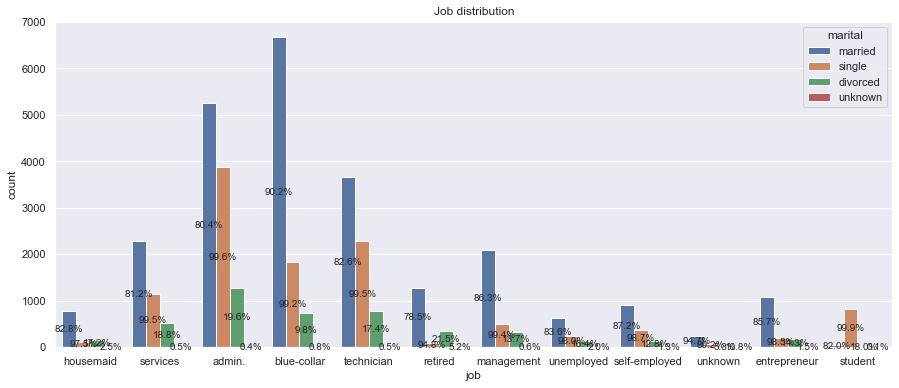

In [344]:
def create_countplot(feature, hue, fontsize, data):
    def place_percentage(patch, percentage, ax):
        x = patch.get_x() + patch.get_width() / 2
        y = patch.get_height() / 2
        ax.annotate(percentage, xy=(x, y), fontsize=fontsize, ha='center', va='center')
        

    sns.set(style="darkgrid")
    plt.figure(figsize=(15, 6))
    ax = sns.countplot(x=feature, hue=hue, data=data)
    plt.title('{} distribution'.format(feature.capitalize()))
    for i in range(len(ax.patches) // 2):
        total = ax.patches[i].get_height() + ax.patches[i + len(ax.patches) // 2].get_height()
        place_percentage(ax.patches[i], '{:.1f}%'.format(100 * ax.patches[i].get_height() / total), ax)
        place_percentage(ax.patches[i + len(ax.patches) // 2], '{:.1f}%'.format(100 * ax.patches[i + len(ax.patches) // 2].get_height() / total), ax)
    plt.show()
    

create_countplot(feature='job', hue='marital', fontsize=10, data=bank_data)

In [333]:
bank_data.loc[bank_data['nr.employed'] < 5090, 'employed_cat'] = 1
bank_data.loc[bank_data['nr.employed'] >= 5090, 'employed_cat'] = 0

In [334]:
bank_data.drop(columns='nr.employed', inplace=True)

* Dealing with missing values ('unknown')

In [22]:
bank_data[bank_data == 'unknown'].count()

age                  0
job                330
marital             80
education         1730
default           8596
housing            990
loan               990
contact              0
month                0
day_of_week          0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
ts_month             0
dtype: int64

In [23]:
def fill_with_mode(features):
    for feature in features:
        bank_data.loc[bank_data[feature] == 'unknown', feature] = bank_data[feature].mode()[0]
        
        
features = ['job', 'marital', 'education', 'default', 'housing', 'loan']
fill_with_mode(features)
bank_data[bank_data == 'unknown'].count()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
ts_month          0
dtype: int64

In [142]:
def target_encoding(features, data):
    X, y = data.drop(columns='y'), data['y']
    target_encode = ce.target_encoder.TargetEncoder(cols=features).fit(X, y)
    X = target_encode.transform(X)
    X['y'] = y
    return X


features = ['marital', 'education', 'job']
bank_data = target_encoding(features, bank_data)
bank_data.head()

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,ts_month,y
0,3,0.100000,0.101561,0.102490,0,0,0,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
1,3,0.081422,0.101561,0.108389,unknown,0,0,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
2,2,0.081422,0.101561,0.108389,0,1,0,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
3,2,0.129667,0.101561,0.082060,0,0,0,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
4,3,0.081422,0.101561,0.108389,0,0,1,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0


In [5]:
def create_categorical_labels(features, data):
    for feature in features:
        data[feature] = LabelEncoder().fit_transform(data[feature])
        
#   , 'day_of_week', 'month'
cat_features = ['marital', 'education', 'job', 'contact', 'poutcome', 'default', 'housing', 'loan']
create_categorical_labels(cat_features, bank_data)

In [6]:
def encode_consecutive(data, feature, encoding):
    data[feature] = data[feature].map(encoding)
    

encode_consecutive(bank_data, 'day_of_week', {'mon': 1, 'tue': 2, 'wed': 3, 'thu': 4, 'fri': 5})
encode_consecutive(bank_data, 'month', {'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12,
                                        'mar': 3, 'apr': 4})

In [49]:
from category_encoders import CountEncoder
bank_data = CountEncoder(cols=['job']).fit(bank_data).transform(bank_data)

In [121]:
def encode_categorical(features, data):
    for feature in features:
        data = pd.concat([data.drop(feature, axis=1), pd.get_dummies(data[feature], prefix=feature, prefix_sep='_',
                                                                     drop_first=True, dummy_na=False)], axis=1)
    display(data.sample(5))
    return data
        
#    'age',  
cat_features = ['job', 'marital', 'education', 'contact', 'poutcome', 'default', 'housing', 'loan', 'day_of_week', 'month']
bank_data = encode_categorical(cat_features, bank_data)

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,...,day_of_week_wed,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
5960,38,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,0,0,0,0,0,1,0,0,0
24450,24,1,999,1,-0.1,93.200,-42.0,4.191,5195.8,0,...,0,0,0,0,0,0,0,1,0,0
37380,24,1,999,0,-2.9,92.201,-31.4,0.879,5076.2,0,...,1,1,0,0,0,0,0,0,0,0
14288,38,3,999,0,1.4,93.918,-42.7,4.962,5228.1,0,...,0,0,0,1,0,0,0,0,0,0
26684,38,2,999,0,-0.1,93.200,-42.0,4.076,5195.8,1,...,0,0,0,0,0,0,0,1,0,0


In [40]:
print(bank_data.default_1.value_counts())
bank_data.drop(columns='default_1', inplace=True)

0    41173
1        3
Name: default_1, dtype: int64


In [7]:
bank_data

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,ts_month
0,3,3,1,0,0,0,0,1,5,1,...,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0,0
1,3,7,1,3,2,0,0,1,5,1,...,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0,0
2,2,7,1,3,0,1,0,1,5,1,...,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0,0
3,2,0,1,1,0,0,0,1,5,1,...,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0,0
4,3,7,1,3,0,0,1,1,5,1,...,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41171,4,5,1,5,0,1,0,0,11,5,...,999,0,1,-1.1,94.767,-50.8,1.028,4963.6,1,25
41172,3,1,1,5,0,0,0,0,11,5,...,999,0,1,-1.1,94.767,-50.8,1.028,4963.6,0,25
41173,3,5,1,6,0,1,0,0,11,5,...,999,0,1,-1.1,94.767,-50.8,1.028,4963.6,0,25
41174,2,9,1,5,0,0,0,0,11,5,...,999,0,1,-1.1,94.767,-50.8,1.028,4963.6,1,25


Balancing

In [4]:
from imblearn.over_sampling import SMOTE 
from collections import Counter
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(bank_data.drop(columns='y'), bank_data.y)
print('Resampled dataset shape %s' % Counter(y_res))

ValueError: could not convert string to float: 'housemaid'

In [ ]:
bank_data = X_res
bank_data['y'] = y_res
bank_data[bank_data.ts_month == 9
         ].y.value_counts()

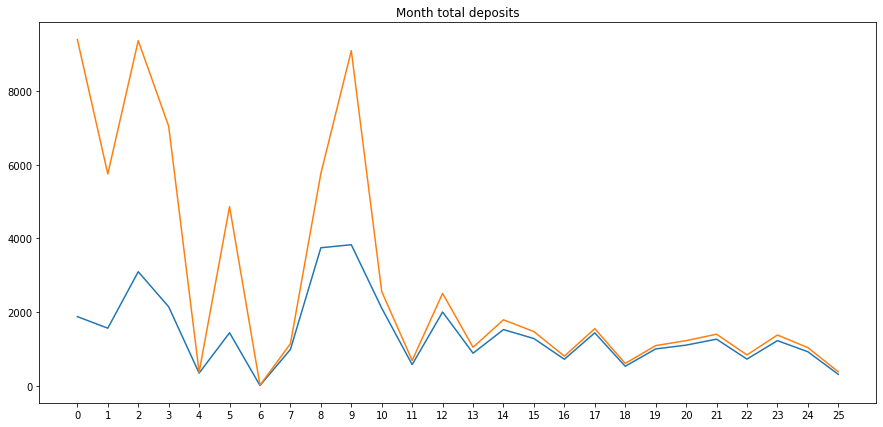

In [24]:
fig = plt.figure(figsize=(15, 7))
plt.plot(bank_data.groupby(['ts_month'])['y'].sum())
plt.plot(bank_data.groupby(['ts_month'])['y'].count())
plt.xticks(np.arange(26))
plt.title('Month total deposits')
plt.show()

### FE check

In [46]:
data = {'train 1': [],
        'train 2': [],
        'train 3': [],
        'train 4': [],
        'train 5': [],
        'mean train': [],
        'valid 1': [],
        'valid 2': [],
        'valid 3': [],
        'valid 4': [],
        'valid 5': [],
        'mean valid': []}
report = pd.DataFrame(data)
report

,train 1,train 2,train 3,train 4,train 5,mean train,valid 1,valid 2,valid 3,valid 4,valid 5,mean valid


In [33]:
"""model = xgb.XGBClassifier(
                        seed = 42,
                        subsample = 0.9,
                        n_estimators=50,
                        reg_alpha=1.8,
                        reg_lambda=1.0,
                        max_depth = 10,
                        learning_rate = 0.3,
                        gamma = 1,
                        colsample_bytree = 0.9
                        )"""

"""X_train = bank_data[bank_data['ts_month'] < i]
X_train = pd.concat([X_train, X_train[X_train.y == 1], X_train[X_train.y == 1]])
y_train = X_train['y']
X_train = X_train.drop(columns=['y'])"""

"X_train = bank_data[bank_data['ts_month'] < i]\nX_train = pd.concat([X_train, X_train[X_train.y == 1], X_train[X_train.y == 1]])\ny_train = X_train['y']\nX_train = X_train.drop(columns=['y'])"

Train scores: [0.7852110115619098, 0.8166366211691983, 0.8319578964771362, 0.8447951558488846, 0.8564411615984167]
Mean train score: 0.8270083693311092
Valid scores: [0.7135824794052633, 0.6551834568579004, 0.7575340896069664, 0.7789918414918409, 0.8102823245084038]
Mean valid score: 0.7431148383740749


'report.loc[len(report)] = [*train_scores, np.mean(train_scores), *valid_scores, np.mean(valid_scores)]\nreport'

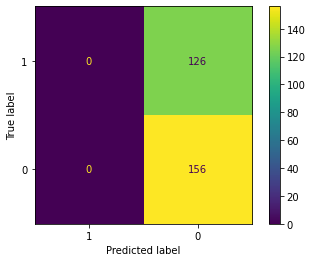

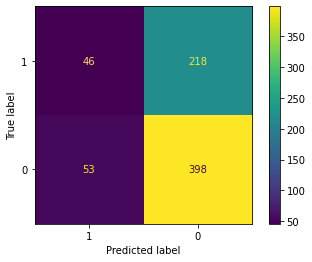

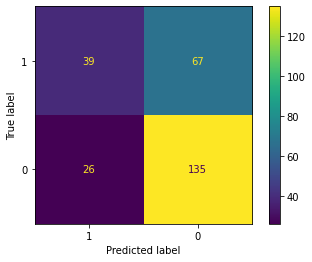

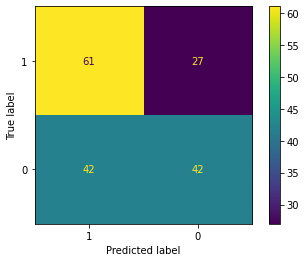

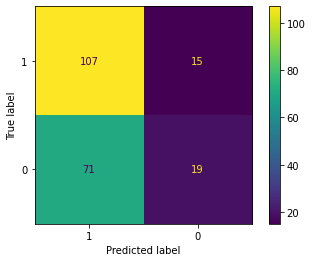

In [16]:
def bank_metric(y_valid, y_pred):
    coeffs = np.array([10, -4, -1, 1])
    cm = confusion_matrix(y_valid, y_pred, labels = [1,0])
    cm = np.reshape(cm, 4)
    return np.dot(cm, coeffs)


def cumgain_auc_score(y_valid, y_pred, normalize=True):
    def calculate_area(y):
        percentiles = np.array_split(y, 100)
        area = 0
        first = 0
        second = 0
        total = sum(y)
        for p in percentiles:
            second += sum(p) / total
            area += (first + second) * 0.5 * 0.01
            first = second
        return area
    
    y_valid = list(y_valid)
    model = [x[1] for x in sorted(zip(y_pred, y_valid), key=lambda x: x[0], reverse=True)]
    wizard = sorted(y_valid, reverse=True)
    if normalize:
        return calculate_area(model) / calculate_area(wizard)
    else:
        return calculate_area(model)


model = xgb.XGBClassifier()
model.set_params(**{
                    'seed': 0,
                    'n_estimators': 92,
                    'max_depth': 7,
                    'reg_alpha': 1.87,
                    'reg_lambda': 1.12,
                    'min_child_weight': 5,
                    'gamma': 1.51,
                    'learning_rate': 0.32,
                    'colsample_bytree': 0.71,
                    'subsample': 0.55
                   })

"""model = RandomForestClassifier()
model.set_params(**{'bootstrap': 'True',
                    'max_depth': 10,
                    'max_features':'sqrt',
                    'min_samples_leaf': 5,
                    'n_estimators': 200})"""

#model = LogisticRegression(C=0.01, penalty='l2', tol=0.01, max_iter=10000)

train_scores = []
valid_scores = []

start_border = 4
train_border = 19
cv_step = 3

for i in range(start_border + cv_step, train_border + 1, cv_step):
    X_train = bank_data[bank_data['ts_month'] < i].drop(columns=['y']) #MinMaxScaler().fit_transform()
    y_train = bank_data[bank_data['ts_month'] < i]['y']
    X_valid = bank_data[bank_data['ts_month'] == i].drop(columns=['y']) #MinMaxScaler().fit_transform()
    y_valid = bank_data[bank_data['ts_month'] == i]['y']
    
    """ sm = SMOTE(random_state=42)
    X_train, y_train = sm.fit_resample(X_train, y_train)"""

    model.fit(X_train, y_train)
    train_scores.append(cumgain_auc_score(y_train, model.predict_proba(X_train)[:,1]))
    valid_scores.append(cumgain_auc_score(y_valid, model.predict_proba(X_valid)[:,1]))
    """cm = confusion_matrix(y_train, [p >= 0.45 for p in model.predict_proba(X_train)[:, 1]], labels = [1, 0])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])
    disp.plot()"""
    cm = confusion_matrix(y_valid, [p >= 0.45 for p in model.predict_proba(X_valid)[:, 1]], labels = [1, 0])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])
    disp.plot()
print('Train scores:', train_scores)
print('Mean train score:', np.mean(train_scores))
print('Valid scores:', valid_scores)
print('Mean valid score:', np.mean(valid_scores))
"""report.loc[len(report)] = [*train_scores, np.mean(train_scores), *valid_scores, np.mean(valid_scores)]
report"""

In [17]:
X, y = bank_data[bank_data.ts_month < 23].drop(columns='y'), bank_data[bank_data.ts_month < 23].y
X_test, y_test = bank_data[bank_data.ts_month >= 23].drop(columns='y'), bank_data[bank_data.ts_month >= 23].y
model.fit(X, y)
pred = model.predict_proba(X_test)[:, 1]
print(cumgain_auc_score(y_test, pred))
print(cumgain_auc_score(y_test, pred, normalize=False))

0.8253958161124175
0.6468936877076411


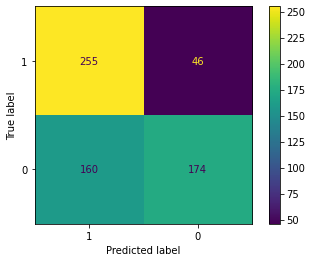

In [18]:
cm = confusion_matrix(y_test, model.predict(X_test), labels = [1, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])
disp.plot()
plt.show()

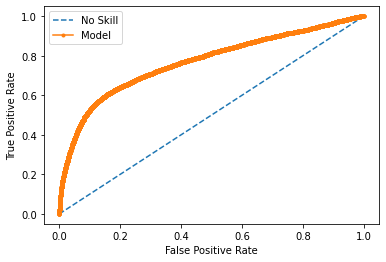

In [19]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split

y = bank_data.y
X = bank_data.drop('y', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.9, random_state = 42)

model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Model')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.show()

In [20]:
len(fpr), len(y_test)

(11452, 37059)

In [21]:
len(thresholds)

11452

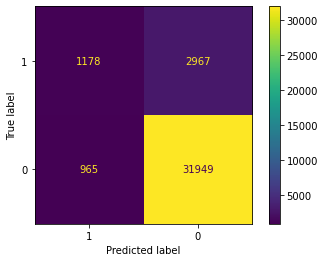

In [22]:
cm = confusion_matrix(y_test, model.predict(X_test), labels = [1, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])
disp.plot()

In [67]:
y.value_counts()

0    36537
1     4639
Name: y, dtype: int64

In [23]:
X = bank_data[(bank_data.ts_month >= 0) & (bank_data.ts_month < 20)].drop(columns='y')
y = bank_data[(bank_data.ts_month >= 0) & (bank_data.ts_month < 20)]['y']
model.fit(X, y)
X_test = bank_data[(bank_data.ts_month >= 20) & (bank_data.ts_month < 23)].drop(columns='y')
y_test = bank_data[(bank_data.ts_month >= 20) & (bank_data.ts_month < 23)]['y']
cumgain_auc_score(y_test, model.predict_proba(X_test)[:,1])

0.8117319269615398

In [36]:
confusion_matrix(y_test, model.predict(X_test), labels = [1,0])

array([[259, 144],
       [ 72, 298]], dtype=int64)

In [37]:
balanced_accuracy_score(y_test, model.predict(X_test))

0.7240426530749111

In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
In a future version, D

Default scope value no_comparison selected, single evaluation line will be plotted.
The label with smallest class is 1
Target class 1, dataset test data and model xgb.


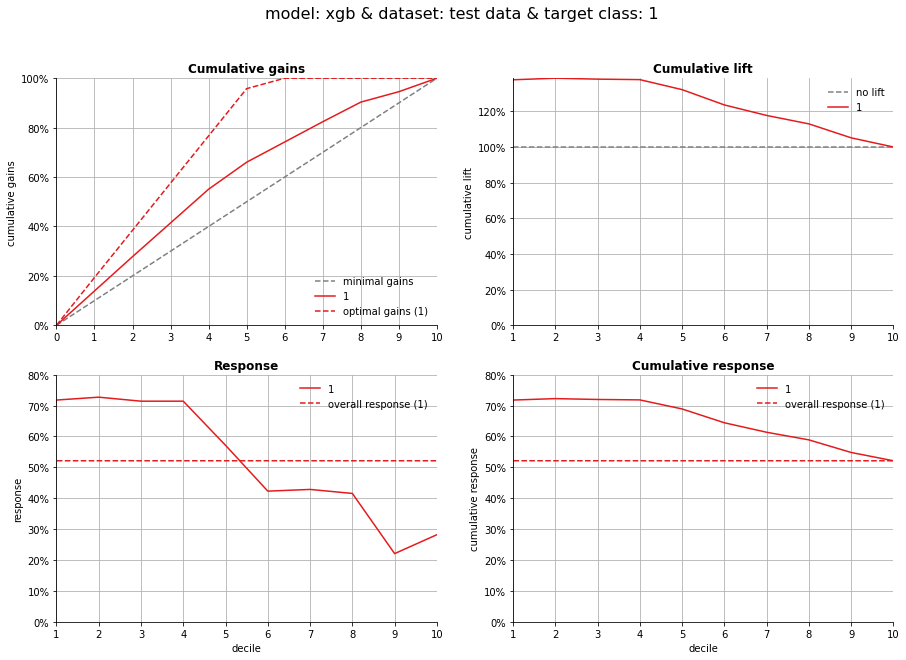

<AxesSubplot:title={'center':'Cumulative gains'}, ylabel='cumulative gains'>

In [24]:
obj = mp.modelplotpy(feature_data = [X, X_test]
                     , label_data = [y, y_test]
                     , dataset_labels = ['train data', 'test data']
                     , models = [model]
                     , model_labels = ['xgb']
                     )

ps = obj.plotting_scope(select_model_label = ['xgb'], select_dataset_label = ['test data'])

mp.plot_all(ps, save_fig = False)

In [17]:
bank_data[bank_data.ts_month < 21].y.value_counts()

0    35955
1     4042
Name: y, dtype: int64

TypeError: only integer scalar arrays can be converted to a scalar index

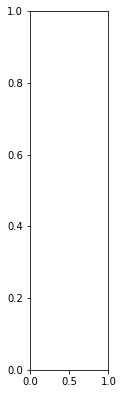

In [14]:
X = X_train.sample(100)
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_valid)
shap.summary_plot(shap_values)
#shap.plots.beeswarm(shap_values)

In [28]:
X = X_train.sample(100)
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)
shap_values[1, 1]
#shap.summary_plot(shap_values[:, :, 1], X)

.values =
-0.088040635

.base_values =
-2.4549396

.data =
4.0

AssertionError: Feature and SHAP matrices must have the same number of rows!

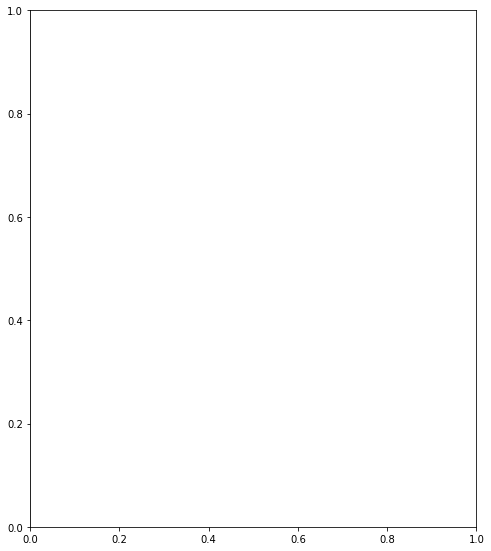

In [55]:

shap.summary_plot(shap_values, X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


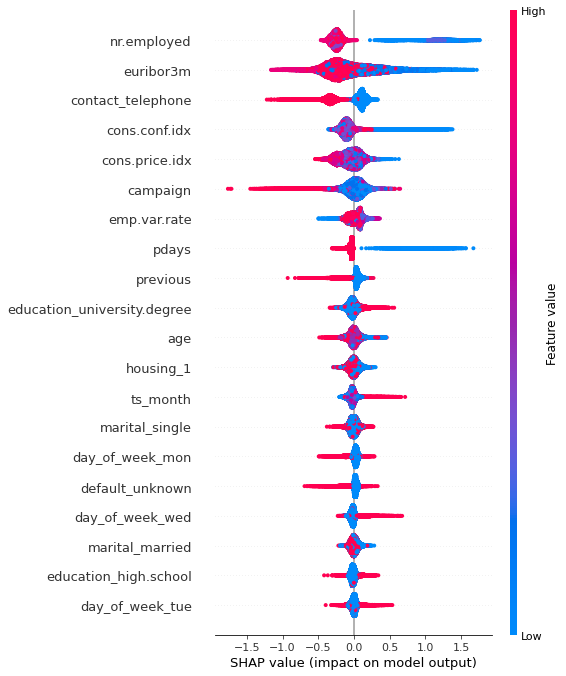

In [34]:
model.fit(X_train, y_train)
explainer = shap.Explainer(model)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train)

In [45]:
len(shap_values.base_values)

40541

### Model Selection & HPO

* Train/valid/test split: I'll split data according to 'ts_month' feature
* Train: 0 - 23 months
* Valid: 24 month
* Test: 25 month

In [1]:
class TimeSeriesCycle:
    def __init__(self,
                 data: pd.DataFrame,
                 models_with_params: dict,
                 metric: object,
                 start_border: int,
                 train_border: int,
                 valid_border: int,
                 test_border: int,
                 cv_step: int,
                 optuna_trials: int
                ):
        self.data = data
        self.models_with_params = models_with_params
        self.metric = metric
        self.start_border = start_border
        self.train_border = train_border
        self.valid_border = valid_border
        self.test_border = test_border    
        self.cv_step = cv_step
        self.optuna_trials = optuna_trials
        self.best_estimators = []
        self.final_estimator = None
        self.final_fitted_estimator = None
        self.shap_values = None
        
   
    def evaluate_model(self, model, params):
        def objective(trial):
            model.set_params(**params(trial))
            train_scores = []
            valid_scores = []
            for i in range(self.start_border + self.cv_step, self.train_border + 1, self.cv_step):
                X_train = self.data[self.data['ts_month'] < i].drop(columns=['y'])
                y_train = self.data[self.data['ts_month'] < i]['y']
                X_valid = self.data[self.data['ts_month'] == i].drop(columns=['y'])
                y_valid = self.data[self.data['ts_month'] == i]['y']

                model.fit(X_train, y_train)
                train_scores.append(self.metric(y_train, model.predict(X_train)))
                valid_scores.append(self.metric(y_valid, model.predict(X_valid)))
            print('Train scores:', train_scores)
            print('Mean train score:', np.mean(train_scores))
            return np.mean(valid_scores)
        
        
        start = time.time()
        study_name = 'study'
        study = optuna.create_study(study_name=study_name, direction='maximize', sampler=optuna.samplers.TPESampler())
        study.optimize(objective, n_trials=self.optuna_trials, show_progress_bar=True, gc_after_trial=True)
        end = time.time()
        
        print('Best score: {}'.format(study.best_value))
        print('Best params: {}'.format(study.best_params))
        print('Taken time: {}'.format(int(end - start)))
        
        self.best_estimators.append((model, study.best_params))
    
    
    def compare_models(self):
        for model, params in self.models_with_params.items():
            print('Hyperparameters tuning for', type(model).__name__)
            self.evaluate_model(model, params)
            print('Tuning completed for {}!'.format(type(model).__name__))

            
        X_train = self.data[self.data['ts_month'] <= self.train_border].drop(columns=['y'])
        y_train = self.data[self.data['ts_month'] <= self.train_border]['y']
        X_valid = self.data[self.data['ts_month'] == self.valid_border].drop(columns=['y'])
        y_valid = self.data[self.data['ts_month'] == self.valid_border]['y']
        
        valid_scores = []
        for model, params in self.best_estimators:
            model.set_params(**params)
            model.fit(X_train, y_train)
            
            train_score = self.metric(y_train, model.predict(X_train))
            valid_score = self.metric(y_valid, model.predict(X_valid))
            print('Train score for {} ='.format(type(model).__name__), train_score)
            print('Validation score for {} = '.format(type(model).__name__), valid_score)
            valid_scores.append(valid_score)
            
        self.final_estimator = self.best_estimators[np.argmax(valid_scores)]
    
    
    def get_predictions(self):
        start = time.time()
        
        model, params = self.final_estimator
        model.set_params(**params)
        print('Final model: ' + str(model))
        X = self.data[self.data['ts_month'] <= self.valid_border].drop(columns=['y'])
        y = self.data[self.data['ts_month'] <= self.valid_border]['y']
        print('Fitting...')
        model.fit(X, y)
        X_test = self.data[self.data['ts_month'] == self.test_border].drop(columns=['y'])
        y_test = self.data[self.data['ts_month'] == self.test_border]['y']
        print('Test score for {} ='.format(type(model).__name__), self.metric(y_test, model.predict(X_test)))
        
        end = time.time()
        print('Took ' + str(int(end - start)) + ' seconds to get final predictions')
        self.final_fitted_estimator = model
    
    
    def explain_model(self, model, data='train'):
        explainer = shap.Explainer(model)
        if data == 'train':
            X = self.data[self.data['ts_month'] <= self.valid_border].sample(1000, random_state=42).drop(columns=['y'])
        else:
            X = self.data[self.data['ts_month'] == self.test_border].drop(columns=['y'])
        self.shap_values = explainer(X)
        shap.summary_plot(self.shap_values, X)

NameError: name 'pd' is not defined

In [5]:
def bank_metric(y_valid, y_pred):
    coeffs = np.array([100, -20, -5, 3])
    cm = confusion_matrix(y_valid, y_pred, labels = [1,0])
    cm = np.reshape(cm, 4)
    return np.dot(cm, coeffs)


log_reg_model = LogisticRegression()
def log_reg_params(trial):
    params = {
        'random_state': 42,
        'tol' : trial.suggest_float('tol' , 1e-6 , 1e-3),
        'C' : trial.suggest_float("C", 1e-2, 1, log=True),
       # 'fit_intercept' : trial.suggest_categorical('fit_intercept' , [True, False]),
       # 'solver' : trial.suggest_categorical('solver' , ['lbfgs','liblinear']),
        "n_jobs" : -1
    }
    return params


svm_model = SVC()
def svm_params(trial):
    params = {
        'random_state': 42,
        'kernel': trial.suggest_categorical('kernel', ['rbf', 'poly', 'linear']),
        'C': trial.suggest_float("C", 0.1, 3.0, log=True),
        'gamma': trial.suggest_categorical('gamma', ['auto', 'scale']),
        'degree': trial.suggest_int("degree", 1, 3, log=True)
    }
    return params


xgb_model = xgb.XGBClassifier()
def xgb_params(trial):
    params = {
        'random_state': 42,
        'n_estimators': trial.suggest_int('n_estimators', 1, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 4),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 2),
        'min_child_weight': trial.suggest_int('min_child_weight', 0, 5),
        'gamma': trial.suggest_float('gamma', 0, 4),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.5, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.9),
        'subsample': trial.suggest_float('subsample', 0.4, 0.9),
        'nthread': -1
    }
    return params

rf_model = RandomForestClassifier()
def rf_params(trial):
    params = {
        'random_state': 42,
        'bootstrap': trial.suggest_categorical('bootstrap', ['True', 'False']),
        'max_depth': trial.suggest_int('max_depth', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 8),
        'n_estimators': trial.suggest_int('n_estimators', 1, 300),
        'n_jobs': -1
    }
    return params

tsc = TimeSeriesCycle(data=bank_data,
                      models_with_params={rf_model: rf_params,
                                          #xgb_model: xgb_params
                                          #log_reg_model: log_reg_params,
                                          #svm_model: svm_params
                                          },
                      metric=roc_auc_score,
                      start_border=0,
                      train_border=23,
                      valid_border=24,
                      test_border=25,
                      cv_step=5,
                      optuna_trials=1 #20
                     )

In [6]:
tsc.compare_models()

[I 2022-11-24 12:48:19,039] A new study created in memory with name: study


Hyperparameters tuning for RandomForestClassifier


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/1 [00:00<?, ?it/s]

Train scores: [0.5586887819904932, 0.5745555029497005, 0.6023453439646276, 0.6541173900344074]
Mean train score: 0.5974267547348071
[I 2022-11-24 12:48:27,977] Trial 0 finished with value: 0.6728101924832515 and parameters: {'bootstrap': 'False', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 292}. Best is trial 0 with value: 0.6728101924832515.
Best score: 0.6728101924832515
Best params: {'bootstrap': 'False', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 292}
Taken time: 9
Tuning completed for RandomForestClassifier!
Train score for RandomForestClassifier = 0.682426471323684
Validation score for RandomForestClassifier =  0.8111014240046498


In [7]:
tsc.get_predictions()

Final model: RandomForestClassifier(bootstrap='False', max_depth=10, max_features='sqrt',
                       min_samples_leaf=2, n_estimators=292, n_jobs=-1,
                       random_state=42)
Fitting...
Test score for RandomForestClassifier = 0.802463054187192
Took 2 seconds to get final predictions


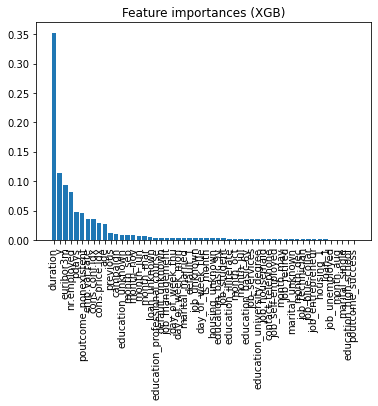

In [8]:
headers = ["name", "score"]
values = sorted(zip(bank_data.columns, tsc.final_fitted_estimator.feature_importances_), key=lambda x: x[1] * -1)
xgb_feature_importances = pd.DataFrame(values, columns = headers)

x_pos = np.arange(0, len(xgb_feature_importances))
plt.bar(x_pos, xgb_feature_importances['score'])
plt.xticks(x_pos, xgb_feature_importances['name'])
plt.xticks(rotation=90)
plt.title('Feature importances (XGB)')

plt.show()

TypeError: only integer scalar arrays can be converted to a scalar index

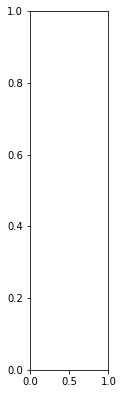

In [9]:
tsc.explain_model(tsc.final_fitted_estimator, data='train')

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


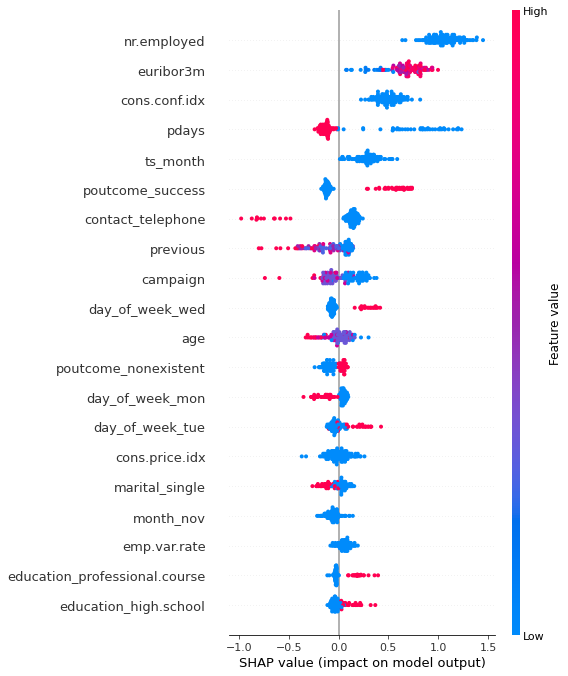

In [81]:
tsc.explain_model(tsc.final_fitted_estimator, data='test')

In [53]:
from sklearn.model_selection import train_test_split
y = bank_data.y
X = bank_data.drop('y', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

obj = mp.modelplotpy(feature_data = [X_train, X_test]
                     , label_data = [y_train, y_test]
                     , dataset_labels = ['train data', 'test data']
                     , models = [tsc.final_fitted_estimator]
                     , model_labels = ['xgb']
                     )

ps = obj.plotting_scope(select_model_label = ['xgb'], select_dataset_label = ['test data'])

NameError: name 'tsc' is not defined

In [54]:
y_test.value_counts()

0    10929
1     1424
Name: y, dtype: int64

In [55]:
cm = confusion_matrix(y_test, model.predict(X_test), labels = [0,1])

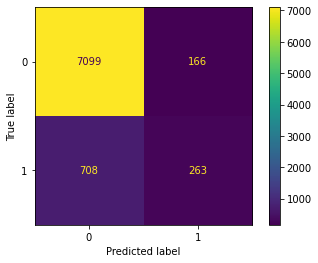

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test, model.predict(X_test), labels = [0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()

color is redundantly defined by the 'color' keyword argument and the fmt string ".r" (-> color='r'). The keyword argument will take precedence.


When we select 10% with the highest probability according to model xgb, this selection holds 71% of all 1 cases in dataset train data.
The cumulative gains plot is saved in D:\EPAM\Bank-Marketing-UCI\notebooks/Cumulative gains plot.png


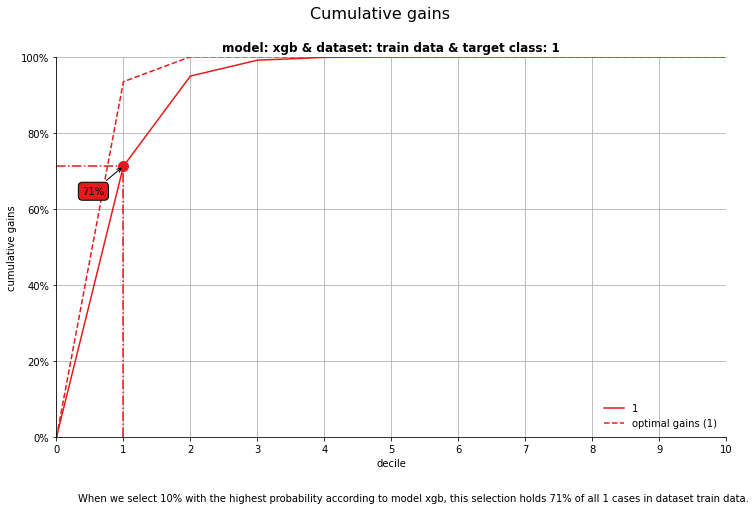

<Figure size 432x288 with 0 Axes>

In [57]:
mp.plot_cumgains(ps, highlight_ntile=1)
plt.show()

color is redundantly defined by the 'color' keyword argument and the fmt string ".r" (-> color='r'). The keyword argument will take precedence.


When we select 20% with the highest probability according to model xgb in dataset test data, this selection for target class 1 is 3.2 times than selecting without a model.
The cumulative lift plot is saved in D:\EPAM\Bank-Marketing-UCI\notebooks/Cumulative lift plot.png


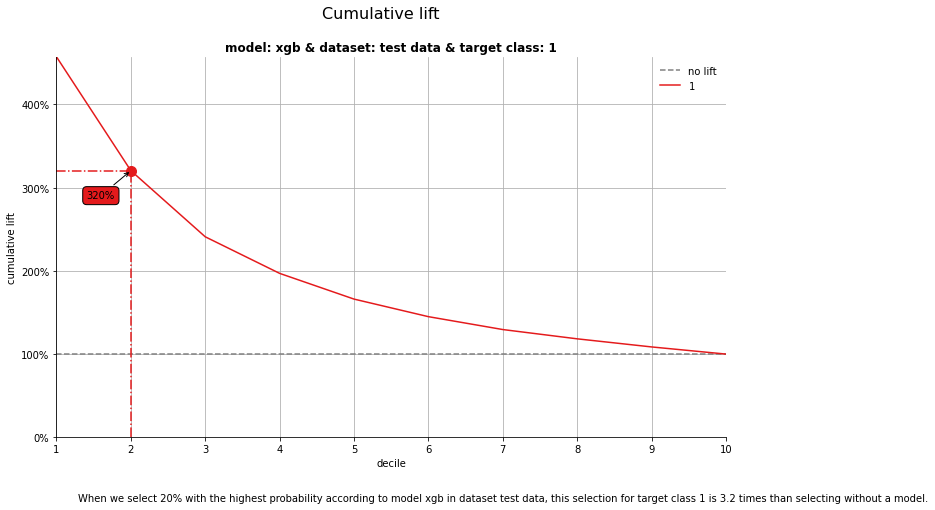

<Figure size 432x288 with 0 Axes>

<AxesSubplot:title={'center':'model: xgb & dataset: test data & target class: 1'}, xlabel='decile', ylabel='cumulative lift'>

In [80]:
mp.plot_cumlift(ps, highlight_ntile = 2)

color is redundantly defined by the 'color' keyword argument and the fmt string ".r" (-> color='r'). The keyword argument will take precedence.


When we select decile 2 from model xgb in dataset test data the percentage of 1 cases in the selection is 20%.
The response plot is saved in D:\EPAM\Bank-Marketing-UCI\notebooks/Response plot.png


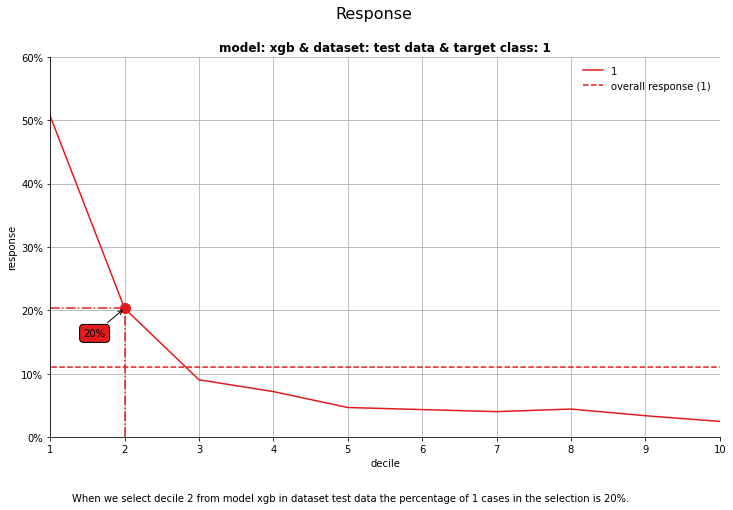

<Figure size 432x288 with 0 Axes>

<AxesSubplot:title={'center':'model: xgb & dataset: test data & target class: 1'}, xlabel='decile', ylabel='response'>

In [83]:
mp.plot_response(ps, highlight_ntile = 2)

color is redundantly defined by the 'color' keyword argument and the fmt string ".r" (-> color='r'). The keyword argument will take precedence.


When we select deciles 1 until 3 according to model xgb in dataset test data the percentage of 1 cases in the selection is 26%.
The cumulative response plot is saved in D:\EPAM\Bank-Marketing-UCI\notebooks/Cumulative response plot.png


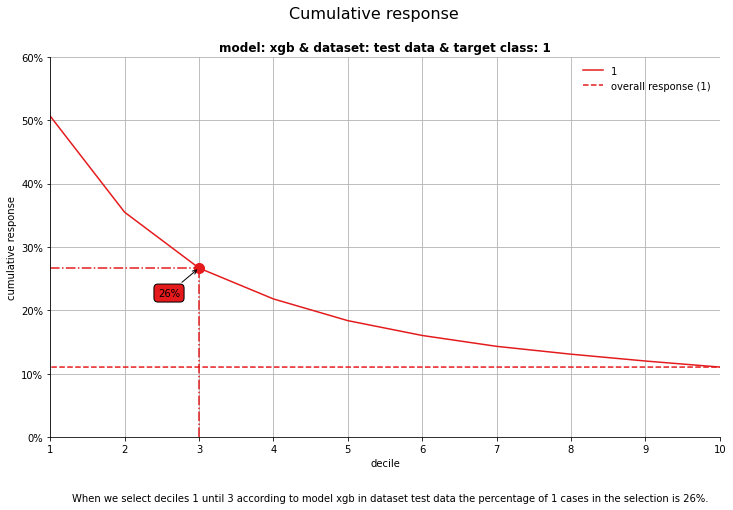

<Figure size 432x288 with 0 Axes>

<AxesSubplot:title={'center':'model: xgb & dataset: test data & target class: 1'}, xlabel='decile', ylabel='cumulative response'>

In [85]:
mp.plot_cumresponse(ps, highlight_ntile = 3)

The plot all plot is saved in Selection model Term Deposits


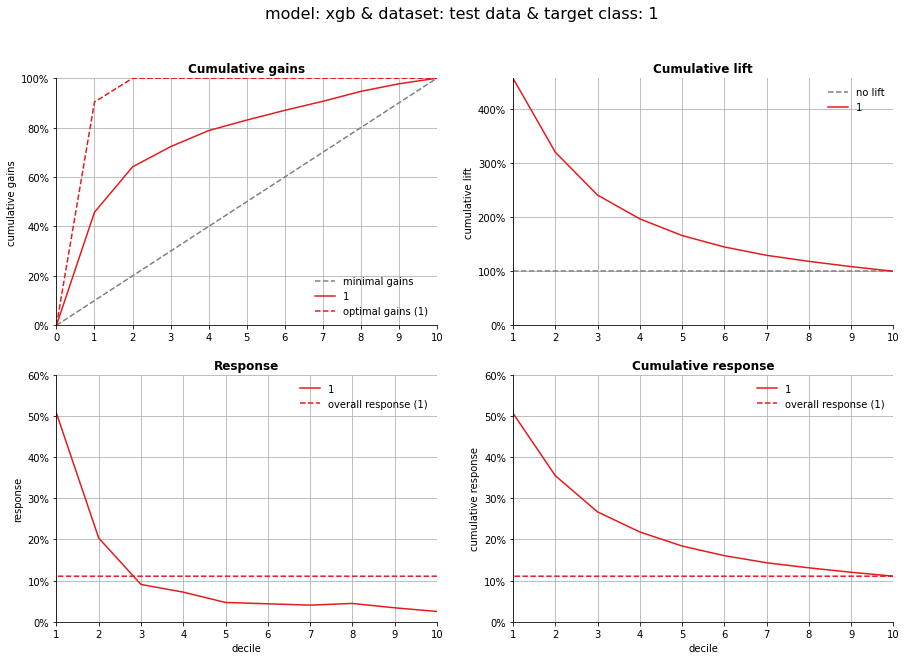

<Figure size 432x288 with 0 Axes>

<AxesSubplot:title={'center':'Cumulative gains'}, ylabel='cumulative gains'>

In [86]:
mp.plot_all(ps, save_fig = True, save_fig_filename = 'Selection model Term Deposits')

In [22]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
X = bank_data.drop(columns='y')
y = bank_data['y']

rf = RandomForestClassifier(n_estimators=500)

scoring = {'accuracy': 'accuracy', 'recall': 'recall'}
scores = cross_validate(rf, X, y, scoring=scoring, cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                        return_train_score=True)
sorted(scores.keys())

['fit_time',
 'score_time',
 'test_accuracy',
 'test_recall',
 'train_accuracy',
 'train_recall']

In [23]:
print('Train accuracy: ', scores['train_accuracy'])
print('Valid accuracy: ', scores['test_accuracy'])
print('Train recall: ', scores['train_recall'])
print('Valid recall: ', scores['test_recall'])

Train accuracy:  [0.98849423 0.98907137 0.98825172 0.9887678  0.98761422]
Valid accuracy:  [0.88950947 0.88609593 0.89350334 0.88755313 0.89338191]
Train recall:  [0.90703314 0.91136853 0.90460792 0.90972784 0.8986796 ]
Valid recall:  [0.29418103 0.27292341 0.31142241 0.29202586 0.30280172]


### Final model quality check